# Step 1. 데이터의 전처리
데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

* 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

* Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

* Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
#pandas의 datetime을 사용해서 시간을 알아보기 쉽게 만듬
data["Time"] = pd.to_datetime(data["Time"], unit= "s")
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


시간을 알아보기 힘들어서 pd.to_datetime 으로 년,월,일,초로 나타내준다.

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
# size() 메서드는 전체 원소의 수를 반환할 때 사용
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
# 세션 길이의 중앙값, 평균값
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [6]:
#세션 길이의 최소값 최대값
session_length.min(), session_length.max()

(20, 2314)

In [7]:
#세션 길이의 99퍼는 906길이 이하
session_length.quantile(0.99)

906.659999999998

In [8]:
# max 2314세션을 분석
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


In [9]:
# cumsum은 누적합 구할때 사용
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

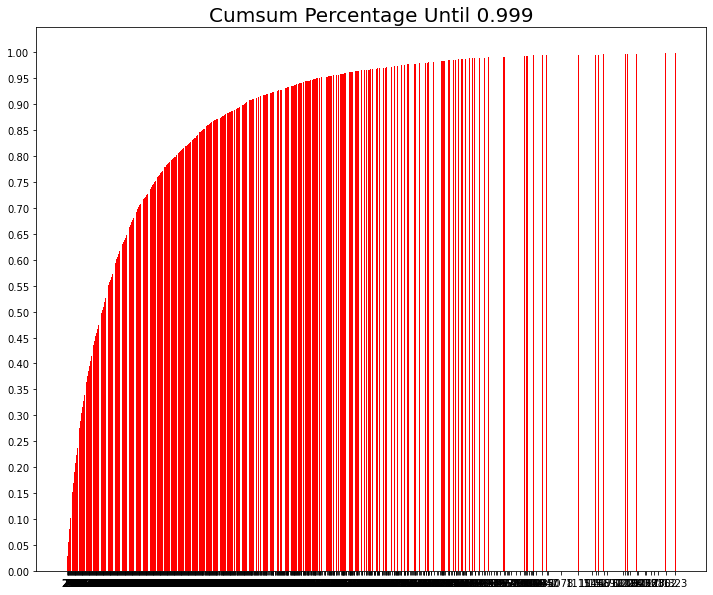

In [10]:
# 세션 길이에 대한 감을 더 잘 파악하기 위해 
# 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [11]:
# 우리가 다루려는 데이터의 시간 관련 정보 대략 3년치를 확인 
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


## Data Cleansing
길이가 1인 세션도 꽤 있습니다. 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해 줍니다.
너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해 줍니다.

In [12]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [13]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## 1.5 Train / Valid / Test split

* 이번 자료에서는 가장 마지막 1일 기간 동안을 Test
* 2일 전부터 1일 전 까지를 valid set
* 마지막 일을 TEST

In [14]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [15]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [16]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [17]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 860249
	 Sessions: 5701
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 00:14:13

* valid Set Stats Info
	 Events: 41662
	 Sessions: 106
	 Items: 3030
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 97700
	 Sessions: 233
	 Items: 3279
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [18]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [19]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다. Data pipeline을 구축

## SessionDataset

In [20]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.
click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [21]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [22]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 859785, 859908, 860249], dtype=int32)

In [23]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5698, 5699, 5700])

## SessionDataLoader

파이썬 문법 중 iterator, generator에 대한 좀 더 친절한 안내가 필요하신 분은 이 자료를 먼저 보시길 권장합니다.

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
__iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [24]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [25]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [26]:
iter_ex = iter(tr_data_loader)

In [27]:
#셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# Step 3. 모델 구성

모델 성능 평가를 위한 지표를 보겠습니다.
모델 성능에 대한 지표로 precision이나 recall이 있습니다.
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.

이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.

추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.
따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.
이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. (MRR은 정답 아이템이 나온 순번의 역수 값입니다.)
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다

## Evaluation Metric

In [28]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [30]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    # hsz모델 사용 lstm보다 더 간단한 모델
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [31]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [32]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 3416)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  520200    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 3416)              174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## Model Training
지금까지 준비한 데이터셋과 모델을 통해 학습을 진행해야 하는데요.

모델 학습에 걸리는 시간은 epoch당 30분이 넘어갑니다. 그러므로 모델 학습 직전까지만 작성해 봅시다.

배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 참고해 주세요.

In [33]:
# train 셋으로 학습하면서 valid 셋으로 검증
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화함

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옴
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옴
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드
                                             # train과 거의 같지만 mrr, recall을 구하는 라인 존재
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [34]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

## 모델1

In [35]:
args1 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model1 = create_model(args1)
train_model(model1, args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:34<01:20,  3.72it/s]


	 - Recall@20 epoch 1: 0.252321
	 - MRR@20    epoch 1: 0.065871



Evaluation:  54%|█████▍    | 350/649 [01:31<01:17,  3.84it/s]


	 - Recall@20 epoch 2: 0.296161
	 - MRR@20    epoch 2: 0.084304



Evaluation:  54%|█████▍    | 350/649 [01:30<01:17,  3.88it/s]

	 - Recall@20 epoch 3: 0.309911
	 - MRR@20    epoch 3: 0.091167



## 모델2

In [36]:
args2 = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.3, lr=0.001, epochs=3, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1055400   
_________________________________________________________________
dropout_2 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_2 (Dense)              (64, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:32<01:18,  3.80it/s]


	 - Recall@20 epoch 1: 0.275134
	 - MRR@20    epoch 1: 0.075916



Evaluation:  54%|█████▍    | 350/649 [01:30<01:17,  3.86it/s]


	 - Recall@20 epoch 2: 0.306786
	 - MRR@20    epoch 2: 0.089852



Evaluation:  54%|█████▍    | 350/649 [01:29<01:16,  3.91it/s]

	 - Recall@20 epoch 3: 0.319063
	 - MRR@20    epoch 3: 0.094706



## 모델3

In [37]:
args3 = Args(tr, val, test, batch_size=64, hsz=150, drop_rate=0.3, lr=0.001, epochs=3, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 150), (64, 150)]    1605600   
_________________________________________________________________
dropout_3 (Dropout)          (64, 150)                 0         
_________________________________________________________________
dense_3 (Dense)              (64, 3416)                515816    
Total params: 2,121,416
Trainable params: 2,121,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:31<01:17,  3.84it/s]


	 - Recall@20 epoch 1: 0.284062
	 - MRR@20    epoch 1: 0.081050



Evaluation:  54%|█████▍    | 350/649 [01:29<01:16,  3.93it/s]


	 - Recall@20 epoch 2: 0.317991
	 - MRR@20    epoch 2: 0.095111



Evaluation:  54%|█████▍    | 350/649 [01:27<01:15,  3.98it/s]

	 - Recall@20 epoch 3: 0.326607
	 - MRR@20    epoch 3: 0.098094



# 회고

* 데이터 전처리하는 부분 따로 공부를 꼭 해야 되겠다는 걸 느꼈다.
* 추천 시스템인 MRR과 Recall@k 등이 이해가 가지 않아 추가적인 설명을 찾아보았다.
* batch size로 인한 배열 오류가 나왔는데 아직까지 왜 그런지 이해를 하지 못했다.
* 모델 3개들의 결과 값들이 너무 좋지가 않다. 시간이 오래 걸려 에폭을 너무 줄인 것도 있을 것이며, 파라미터 값을 하나씩 다양하게 해보지 않아서 어떤 파라미터가 더 효과적으로 영향을 끼치는지 아직 잘 모르겠다.

추천시스템은 요즘 필수적으로 알아야 한다고 생각하고 재밌기도해서 좀 더 찾아보고 다시 살펴봐야겠다.

### Recall@k  
추천시스템은 하나의 아이템만 추천하지 않으며 정답도 여러개가 될 수 있다. 따라서 등장한 것이 바로 K다. K는 추천 아이템 수를 의미  
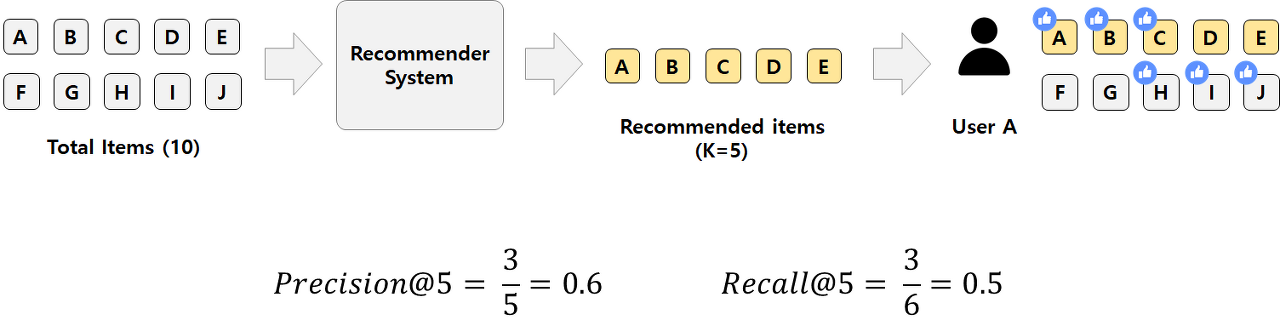

1) Precision@K
  * Precision은 내가 1로 예측한 것 중에 실제 1이 얼마나 있는지 비율을 나타낸다.
  * Precision@K는 내가 추천한 아이템 K개 중에 실제 사용자가 관심있는 아이템의 비율
  * 그림의 예시를 보면 추천한 아이템은 5개, 추천한 아이템 중에서 사용자가 좋아한 아이템은 3개다. 따라서, Precision@5=0.6
  
2) Recall@K
  * Recall은 실제 모든 1 중에서 내가 1로 예측한 것이 얼마나 되는지 비율을 나타낸다. 
  * Recall@K는 사용자가 관심있는 모든 아이템 중에서 내가 추천한 아이템 K개가 얼마나 포함되는지 비율
  * 그림의 예시를 보면 사용자가 좋아한 모든 아이템이 6개, 그 중에서 나의 추천에 포함되는 아이템이 3개다. 따라서, Recall@5=0.5

> https://sungkee-book.tistory.com/11

### 추천 시스템 평가 척도 중 MRR    

기존의 머신러닝 metric들은 순위 정보를 반영하지 못한다는 한계가 있기 때문에 
추천 시스템에 적용하기가 제한적  
이 두가지 목표를 달성하기 위해서, 다음의 세가지 척도를 사용할 수 있다.

1) MRR (Mean Reciprocal Rank, 평균 상호 순위)  
2) MAP (Mean Average Precision, 평균 일반 정밀도)  
3) NDCG (Normalized Discounted Cumulative Gain, 표준화 절감 누적 이득)    

1,2번은 binary relevance based metrics로, 이진적으로 좋은 추천인지 나쁜 추천인지를 가려낸다.  
아래의 3번은 utility based metric의 일종으로, 상대적/절대적 좋음으로 까지 확장
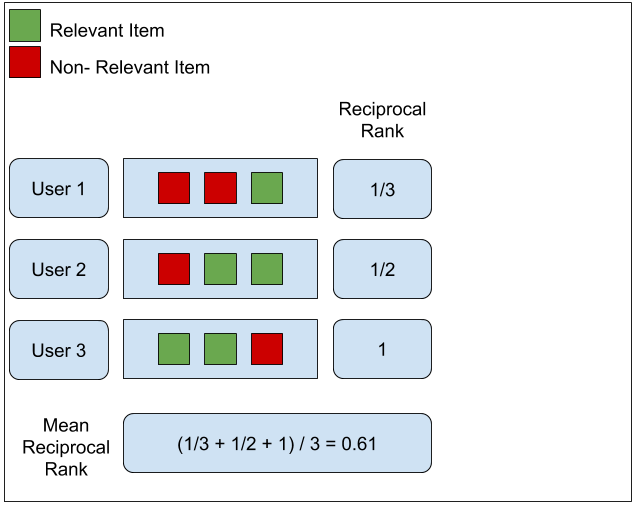

#### 장점  
1) 계산이 쉽고, 해석이 간단하다.  
2) 가장 처음 등장하는 유관 상품 초점을 둔다.  
(유저가 '나를 위한 최적상품'을 찾고 있을 때 가장 적합)  
3) 고객이 잘 알고있는 아이템을 찾고 있을 때 적합함.   
(예를들어 방향 탐색이나, 사실 검색의 경우.)

#### 단점  
1) 추천 리스트의 나머지 제품에 대해 측정 안함.   
 (리스트의 하나에만 집중함.)  
2) 유관 상품을 1개 품고 있는 리스트나 여러 개 품고 있는 리스트나 동일하게 취급함.   
(이것이 목적이면 상관없긴 하다)  
3) 유관 상품의 목록을 원하는 경우 좋은 척도가 아닐것.   
(여러 개 유관품목중 비교를 원하는 경우)  

> https://blog.naver.com/nilsine11202/221910414208